In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from IPython.core.display import HTML

In [2]:
from curve import USDCurve, shock_curve, adjust_sofr1m
from future_option import SOFRFutureOptionVolGrid, shock_surface_curve, shock_surface_vol

In [3]:
def pprint(df: pd.Series | pd.DataFrame):
    df = df if isinstance(df, pd.DataFrame) else df.to_frame()
    display(HTML(df.to_html()))

In [4]:
today = dt.datetime(2024, 11, 1)

In [45]:
ff_px = pd.Series({
    "FFX4": 95.359,
    "FFZ4": 95.5075,
    "FFF5": 95.6375,
    "FFG5": 95.7725,
    "FFH5": 95.8375,
    "FFJ5": 95.94,
    "FFK5": 96.035,
    "FFM5": 96.1125,
    "FFN5": 96.1925,
    "FFQ5": 96.2575,
    "FFU5": 96.2875,
    "FFV5": 96.3275,
    "FFX5": 96.365
}, name="FF")

sofr1m_px = pd.Series({
    "SERX4": 95.341,
    "SERZ4": 95.4625,
    "SERF5": 95.5925,
    "SERG5": 95.7425,
    "SERH5": 95.805,
    "SERJ5": 95.9125,
    "SERK5": 96.0075,
    "SERM5": 96.0725,
    "SERN5": 96.1525,
    "SERQ5": 96.215,
    "SERU5": 96.2375,
    "SERV5": 96.275,
    "SERX5": 96.455
}, name="SOFR1M")

sofr3m_px = pd.Series({
    "SFRU4": 95.226,
    "SFRZ4": 95.6375,
    "SFRH5": 95.9425,
    "SFRM5": 96.1575,
    "SFRU5": 96.2775,
    "SFRZ5": 96.3375,
    "SFRH6": 96.36,
    "SFRM6": 96.3575,
    "SFRU6": 96.3425,
    "SFRZ6": 96.3225,
    "SFRH7": 96.3125,
    "SFRM7": 96.3075,
    "SFRU7": 96.3025,
    "SFRZ7": 96.2925,
    "SFRH8": 96.2775,
    "SFRM8": 96.2625
}, name="SOFR3M")

In [9]:
ff = USDCurve("FF", today).calibrate_future_curve(ff_px)

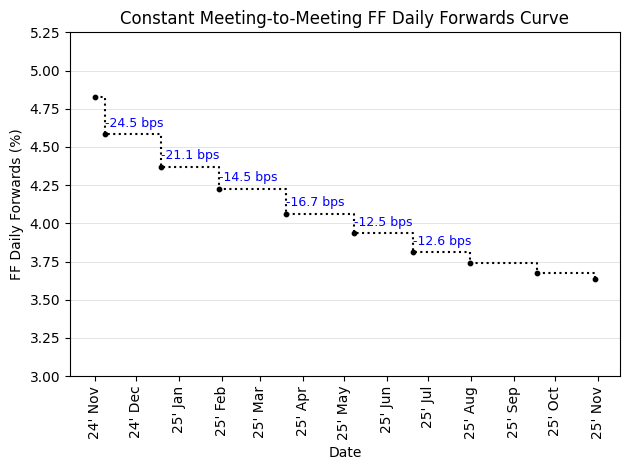

In [10]:
ff.plot_effective_rates(10, 6)

In [11]:
pprint(ff.get_effective_rates())

,FF
2024-11-01,4.8278
2024-11-08,4.5829
2024-12-19,4.3717
2025-01-30,4.2272
2025-03-20,4.0606
2025-05-08,3.9353
2025-06-20,3.8096
2025-07-31,3.7422
2025-09-18,3.6751
2025-10-30,3.6354


In [39]:
sofr = USDCurve("SOFR", today).calibrate_future_curve(sofr1m_adj, sofr3m_px)

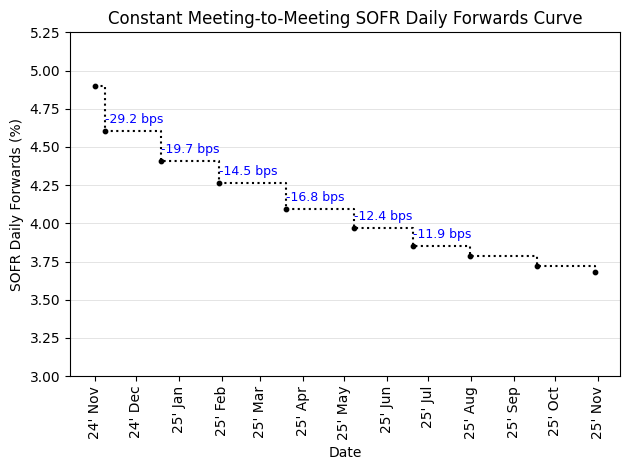

In [40]:
sofr.plot_effective_rates(10, 6)

In [41]:
pprint(sofr.get_effective_rates()[:10])

,SOFR
2024-11-01,4.8966
2024-11-08,4.6048
2024-12-19,4.4082
2025-01-30,4.2633
2025-03-20,4.0952
2025-05-08,3.9715
2025-06-20,3.8521
2025-07-31,3.7853
2025-09-18,3.7208
2025-10-30,3.6828


In [82]:
def adjust_sofr1m(ff: pd.Series, sofr1m: pd.Series) -> pd.Series:
    """
    This function assumes linear basis with outliers for sofr-ff, and adjust SOFR1m futures prices
    based on FF1m prices + model basis.
    This is done because FF futures has sufficient liquidity and volume, where SOFR1M futures barely trades after front
    contracts, and pricing is often off near the tail.
    :param ff:
    :param sofr1m:
    :return:
    """

    market_basis = ff.values - sofr1m.values
    adjusted_basis = market_basis.copy()

    for i in range(len(market_basis)):
        leave_one_out_values = np.delete(market_basis, i)
        std = np.std(leave_one_out_values)
        threshold = 2 * std
        mean = np.mean(leave_one_out_values)
        
        if market_basis[i] > mean + threshold:
            adjusted_basis[i] = mean
        elif market_basis[i] < mean - threshold:
            adjusted_basis[i] = mean

    return pd.Series(np.round(ff.values - adjusted_basis, 4), index=sofr1m.index, name="SOFR1M")